In [1]:
from torch_geometric.datasets import TUDataset
import networkx as nx
from torch_geometric.utils import to_networkx
from torch_geometric.nn import global_mean_pool
from torch_geometric.loader import DataLoader
from torch_geometric.utils import k_hop_subgraph
from torch import nn
from torch_geometric.nn import GCNConv
import torch
import matplotlib.pyplot as plt

/Users/akshitsinha3/Library/CloudStorage/OneDrive-InternationalInstituteofInformationTechnology/Projects/AdversarialUnlearning/.venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [119]:
seed=24
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)

In [2]:
dataset= TUDataset(root="./", name="MUTAG").shuffle()
train_set= dataset[:150]
test_set= dataset[150:]
train_loader= DataLoader(train_set, 16)
test_loader= DataLoader(test_set, 16)

TypeError: LocalFileSystem.mv() takes 3 positional arguments but 4 were given

In [3]:
class GNN(nn.Module):
    def __init__(self, num_features, hidden1, hidden2, num_classes):
        super().__init__()
        self.conv1 = GCNConv(num_features, hidden1)
        self.conv2 = GCNConv(hidden1, hidden2)
        self.linear = nn.Linear(hidden2, num_classes)
        self.relu = nn.ReLU()

    def forward(self, data):
        x, adj = data.x, data.edge_index
        #Graph Convolutions
        x = self.conv1(x, adj)
        x = self.relu(x)
        x = self.conv2(x, adj)
        x = self.relu(x)

        #Aggregation Step
        x = global_mean_pool(x, data.batch) #output is shape (batch len, embedding len)

        #Prediction Step
        x= self.linear(x)

        return x

    def get_embeddings(self, data):
        x, adj = data.x, data.edge_index
        x = self.conv1(x, adj)
        x = self.relu(x)
        x = self.conv2(x, adj)
        x = self.relu(x)

        #No need for global mean pool anymore because that combines all the nodes of a graph
        # x = global_mean_pool(x, data.batch)
        return x

In [4]:
device= "cuda" if torch.cuda.is_available() else "cpu"
gnn =GNN(dataset[0].num_features, 16, 8, dataset.num_classes)
loss= nn.CrossEntropyLoss()
optim= torch.optim.Adam(params=gnn.parameters(), lr=1e-3)

NameError: name 'dataset' is not defined

In [5]:
train_loss=[]
test_loss=[]

for epoch in range(200):
    loss_avg=0
    train_batch_len= len(train_loader)
    test_batch_len= len(test_loader)

    for data in train_loader:
        gnn.train()
        data=data
        pred= gnn(data)
        loss_v= loss(pred, data.y)
        loss_avg+=loss_v
        optim.zero_grad()
        loss_v.backward()
        optim.step()

    test_loss_avg=0
    with torch.no_grad():
        for data in test_loader:
            gnn.eval()
            gnn.train()
            data=data
            pred= gnn(data)
            loss_v= loss(pred, data.y)
            test_loss_avg+=loss_v

    train_loss.append(loss_avg.item()/train_batch_len)
    test_loss.append(test_loss_avg.item()/test_batch_len)

NameError: name 'train_loader' is not defined

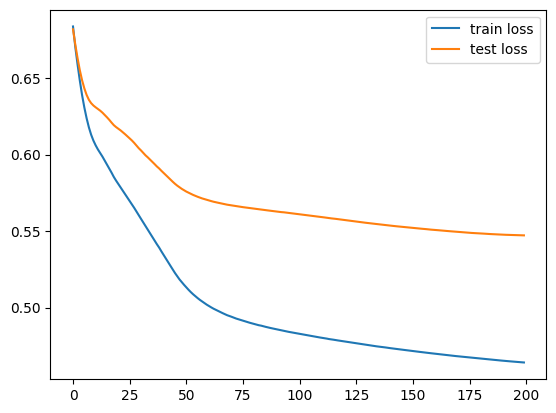

In [124]:
plt.plot(train_loss, label="train loss")
plt.plot(test_loss, label="test loss")
plt.legend()

In [125]:
train_embeddings = []
train_features = []
for x in train_loader:
    out = gnn.get_embeddings(x)
    train_embeddings.extend(out)
    train_features.extend(x.x)

test_embeddings = []
test_features = []
for x in test_loader:
    out = gnn.get_embeddings(x)
    test_embeddings.extend(out)
    test_features.extend(x.x)

element_dict = {0: "C", 1: "N", 2: "O", 3: "F", 4: "I", 5: "Cl", 6: "Br"}

In [126]:
#considering first node now
embeddings1= gnn.get_embeddings(dataset[0])
embeddings2= gnn.get_embeddings(dataset[1])
ds= torch.vstack([embeddings1, embeddings2])
ds.shape, embeddings1.shape, embeddings2.shape

(torch.Size([46, 8]), torch.Size([22, 8]), torch.Size([24, 8]))

In [127]:
#Creating a dataset for test probing
#Aim: to see if the GCN layers still convey some information about the element they belong to
#Kind of like node classification
X_train_probe = torch.vstack([gnn.get_embeddings(x) for x in train_loader])
X_test_probe = torch.vstack([gnn.get_embeddings(x) for x in test_loader])

y_train_probe_i = torch.vstack([x.x for x in train_loader])
y_test_probe_i = torch.vstack([x.x for x in test_loader])

y_train_probe = torch.tensor(
    [element_dict[val.item()] == "O" for val in y_train_probe_i.argmax(dim=1)],
    dtype=torch.int32,
)
y_test_probe = torch.tensor(
    [element_dict[val.item()] == "O" for val in y_test_probe_i.argmax(dim=1)],
    dtype=torch.int32,
)

In [128]:
from torch.utils.data import Dataset, DataLoader

class CustomDataset(Dataset):
    def __init__(self, X, y):
        super().__init__()
        self.X= X.detach()
        self.y= torch.tensor(y, dtype=torch.int64).detach()

    def __len__(self):
        return len(self.X)

    def __getitem__(self, index) :
        return self.X[index], self.y[index]

train_probe_dataset= CustomDataset(X_train_probe, y_train_probe)
test_probe_dataset= CustomDataset(X_test_probe, y_test_probe)
train_probe_loader= DataLoader(train_probe_dataset, batch_size=16)
test_probe_loader= DataLoader(test_probe_dataset, batch_size=16)

C:\Users\deban\AppData\Local\Temp\ipykernel_3292\1442554303.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.y= torch.tensor(y, dtype=torch.int64).detach()


In [129]:
#train a simple network for classifying the embeddings
class Network(nn.Module):
    def __init__(self, num_features, num_classes):
        super().__init__()
        self.network= nn.Sequential(
            nn.Linear(num_features, 16),
            nn.ReLU(),
            nn.Linear(16, 16),
            nn.ReLU(),
            nn.Linear(16, num_classes)
        )

    def forward(self, data):
        return self.network(data)

net= Network(8, 2)
loss_probe= nn.CrossEntropyLoss()
optim_probe= torch.optim.Adam(net.parameters(), lr=1e-3)
num_epoch= 100

In [130]:
train_probe_loss=[]
test_probe_loss=[]

for epoch in range(num_epoch):
    train_loss=0
    test_loss=0

    for X, y in train_probe_loader:
        net.train()
        optim_probe.zero_grad()
        y_pred= net(X)
        loss_val= loss_probe(y_pred, torch.tensor(y, dtype=torch.int64))
        loss_val.backward()
        train_loss+= loss_val
        optim_probe.step()

    with torch.no_grad():
        for X, y in test_probe_loader:
            net.eval()
            y_pred= net(X)
            loss_val= loss_probe(y_pred, y)
            test_loss+= loss_val

    train_loss/=len(train_probe_loader)
    test_loss/=len(test_probe_loader)

    train_probe_loss.append(train_loss.item())
    test_probe_loss.append(test_loss.item())

C:\Users\deban\AppData\Local\Temp\ipykernel_3292\2962653898.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  loss_val= loss_probe(y_pred, torch.tensor(y, dtype=torch.int64))


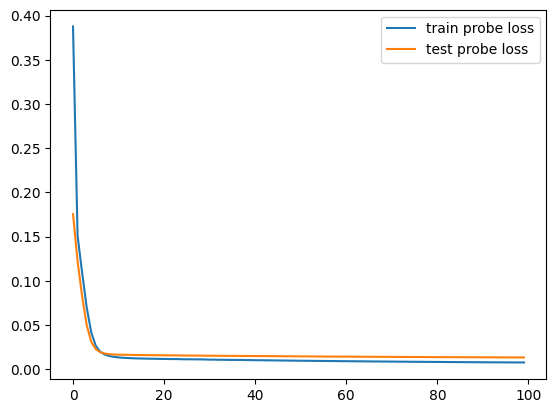

In [131]:
plt.plot(train_probe_loss, label="train probe loss")
plt.plot(test_probe_loss, label="test probe loss")
plt.legend()